In [1]:
import pyodbc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
conn2 = pyodbc.connect('DRIVER={SQL Server};'
                                'Server=finesxxx.xxxx.xxxxxxx.amazonaws.com,xxxx;'
                                'Database=xxxxxxxx;'
                                'uid=xxxxx;pwd=xxxxxx;'
                                'TrustServerCertificate=yes;')
print ("Connected")
cursor = conn2.cursor()

In [3]:
query = '''
SELECT *
FROM modeling_data2
'''

In [4]:
df = pd.read_sql_query(query, con= conn2)

In [5]:
# df.to_csv('new modeling data.csv', index  =False)

In [6]:
#df = pd.read_csv('new modeling data.csv')

In [7]:
df.shape

(1310, 11)

In [8]:
df.head(3)

,video_id,comedian,year,year_month,months_since_upload,video_duration,view_count,like_count,day_of_week,weekend_weekday,monthly_videos_count
0,-_lBNFG22e8,Broda Shaggi,2021,2021-01,15,5,607779,15480,Monday,Weekday,6
1,-6RDdP0_khU,Taaooma,2020,2020-10,18,2,677916,17698,Thursday,Weekday,8
2,-7V5dA3Lxb0,Mr macaroni,2020,2020-02,26,2,389383,5238,Wednesday,Weekday,11


In [9]:
new_df = df[['comedian', 'year', 'months_since_upload', 'video_duration',
       'view_count', 'day_of_week', 'weekend_weekday', 'monthly_videos_count','like_count']] 

In [10]:
new_df = pd.get_dummies(new_df, columns = ['comedian', 'year', 'day_of_week', 'weekend_weekday']) 

In [11]:
X_new =new_df.columns.drop('like_count')
X = new_df[list(X_new)]
y = new_df['like_count']

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [13]:
SEED = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= SEED)

In [14]:
def random_forest_model():
    rf = RandomForestRegressor(random_state= SEED)

    params_grid = {'n_estimators': np.arange(200, 250, 10),
            'min_samples_leaf': np.arange(0, 0.01, 0.001)}

    search = RandomizedSearchCV(estimator = rf, param_distributions= params_grid, cv = 3, scoring = 'neg_mean_absolute_error',
                     n_iter = 20, verbose = 0, n_jobs = -1)

    result = search.fit(X_train, y_train)

    best_hyperparams = result.best_params_
    best_score = result.best_score_

    best_model = result.best_estimator_
    print(f"Best hyperparams: {best_hyperparams} \nBest score: {best_score}")
    return best_model

In [15]:
model = random_forest_model()

C:\Users\tuneG\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [-1768.05492082 -1594.20818428 -1642.19502451            nan
 -1603.06622902 -1640.13084087 -1765.97056833 -1688.18250139
 -1737.2219843  -1738.88672284            nan -1641.6052878
 -1600.139994              nan -1687.61904222 -1769.03642145
 -1602.34593543 -1737.21110557 -1687.61904222 -1601.30284396]
  warnings.warn(


Best hyperparams: {'n_estimators': 230, 'min_samples_leaf': 0.002} 
Best score: -1594.208184282744


In [16]:
y_pred = model.predict(X_test)
mae_test = MAE(y_test, y_pred)
print(mae_test)

1596.8981257836185


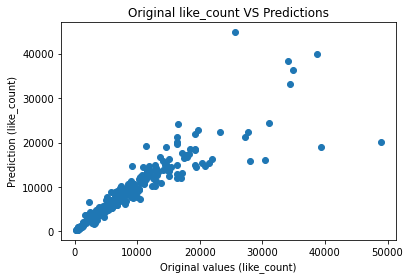

In [17]:
plt.scatter(x = y_test, y = y_pred)
plt.xlabel('Original values (like_count)')
plt.ylabel('Prediction (like_count)')
plt.title('Original like_count VS Predictions')
plt.show()

### Feature Importance

In [18]:
importance_rf =  pd.Series(model.feature_importances_, index = X_train.columns)

In [19]:
sorted_importances_rf = importance_rf.sort_values()

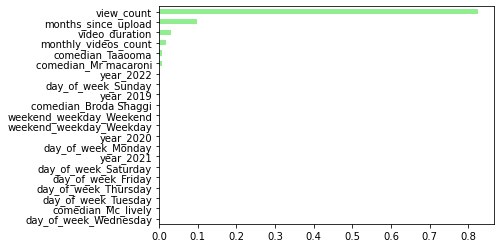

In [20]:
sorted_importances_rf.plot(kind = 'barh', color = 'lightgreen')
plt.show()